<a href="https://colab.research.google.com/github/atreyat12/Explainable_Techniques_II/blob/main/AT_XAI_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #4
### Explainable Techniques II
### Atreya Tadepalli

#### Include the button below. Change the link to the location in your github repository:
#### Example: https://colab.research.google.com/github/yourGHName/yourREPOName/blob/yourBranchName/yourFileName.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1i9PUjl7LCjlWkGGjb4wkgfyhoNwZSM5r?usp=sharing)

👉 Make sure to delete the helper markdown below in your own notebook!

## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI" # Change to your repo name
git_path = 'https://github.com/AIPI-590-XAI/Duke-AI-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'Duke-AI-XAI'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 94 (delta 34), reused 63 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 7.12 MiB | 18.36 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/Duke-AI-XAI/templates
template.ipynb


#### Using environment variables in Google Colab

In Google Colab, locate the key button on the left side of the screen. You can enter in any environment variables or API keys here and they will remain private.

Then add the environment variables to your notebook using the code below.

Make sure to document in your notebook if you are using API keys and how to get them (ie share a link for documentation to get a Hugging Face API Key if you are using Hugging Face)

## Import Packages

To import packages, I reference Dr. Bent's global explanations notebook for the necessary packages. However, I differ slightly with respect to the Accumulated Local Effects package, as alepython was not working for me.

In [ ]:
pip install PyALE

In [ ]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# XAI
import shap
from PyALE import ale
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance


## Dataset

The dataset I selected was one related to cirrhosis occurences. Cirrhosis is a disease that results from chronic liver damage, often due to hepatitis or liver disease. This dataset comes from the Mayo Clinic, which conducted a placebo-controlled randomized drug trial to treat cirrhosis between the years of 1974 and 1984, and recorded the results associated with 424 individuals. The dataset has 18 columns, one of which is the output variable, which is the state of the patient (Dead, Censored, or Censored following Liver Transplant). As I understand, censored means that the patient is alive by the time the study was concluded in 1984. I sourced this dataset using UC Irvine's Machine Learning Repository of datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cirrhosis=pd.read_csv('/content/drive/My Drive/Colab Notebooks/cirrhosis.csv')

## Correlations and Exploration

In [ ]:
cirrhosis.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


I will identify null values from each column that need to be cleaned.

In [ ]:
#Identify Null values
pd.isnull(cirrhosis).sum()

,0
ID,0
N_Days,0
Status,0
Drug,106
Age,0
Sex,0
Ascites,106
Hepatomegaly,106
Spiders,106
Edema,0


**In reviewing the dataset, I see that 106 patients toward the end of the dataset do not have most metrics registered, so I will choose to omit these patients from analysis, given the presence of null values**

In [ ]:
cirrhosis_refined=cirrhosis[0:312]

**I will convert several categorical variables to numerical to improve a correlation analysis, and also potentially improve the associated explainability technique effectiveness**

In [ ]:
#Conversion of Sex, with Male as 1 and Female as 0
cirrhosis_refined["Sex"] = cirrhosis_refined["Sex"].map({"F": 0, "M": 1})


#Conversion of Yes and No to 1 and 0, respectively,
#for three medical conditions
cirrhosis_refined["Ascites"] = cirrhosis_refined["Ascites"]\
.map({"N": 0, "Y": 1})
cirrhosis_refined["Hepatomegaly"] = cirrhosis_refined["Hepatomegaly"]\
.map({"N": 0, "Y": 1})
cirrhosis_refined["Spiders"] = cirrhosis_refined["Spiders"]\
.map({"N": 0, "Y": 1})

#Same for treatment or placebo ("Drug" column)
cirrhosis_refined["Drug"] = cirrhosis_refined["Drug"].\
map({"Placebo": 0, "D-penicillamine": 1})


/tmp/ipython-input-2005919953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_refined["Sex"] = cirrhosis_refined["Sex"].map({"F": 0, "M": 1})
/tmp/ipython-input-2005919953.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_refined["Ascites"] = cirrhosis_refined["Ascites"]\
/tmp/ipython-input-2005919953.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

**Given the CL status reflects those surviving, but with a liver transplant, for the purpose of conversion to a binary indicator, I will update to surviving.**

In [ ]:
cirrhosis_refined["Status"].replace(to_replace='CL', value='C', inplace=True)

/tmp/ipython-input-3253423281.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cirrhosis_refined["Status"].replace(to_replace='CL', value='C', inplace=True)
/tmp/ipython-input-3253423281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_refined["Status"].replace(to_replace='CL', value='C', inplace=True)


In [ ]:
##Binary conversion of status, where 0 denotes surviving and 1 denotes death
cirrhosis_refined["Status"] = cirrhosis_refined["Status"].map({"C": 0, "D": 1})

/tmp/ipython-input-2837299561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_refined["Status"] = cirrhosis_refined["Status"].map({"C": 0, "D": 1})


**For the Edema variable, S denotes those who would have edema without the presence of therapy, so these will be relabeled to "Y", since they would have edema if not for therapy.**

In [ ]:
cirrhosis_refined["Edema"] = cirrhosis_refined["Edema"].replace({"S": "Y"})

/tmp/ipython-input-1528428445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_refined["Edema"] = cirrhosis_refined["Edema"].replace({"S": "Y"})


In [ ]:
#Conversion to numerical variable
cirrhosis_refined["Edema"] = cirrhosis_refined["Edema"].map({"N": 0, "Y": 1})

/tmp/ipython-input-1038040072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_refined["Edema"] = cirrhosis_refined["Edema"].map({"N": 0, "Y": 1})


In [ ]:
cirrhosis_refined.head(5)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,1,1,21464,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,0,1,20617,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,1,1,25594,1,0,0,0,1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,1,1,19994,0,0,1,1,1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,0,0,13918,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


**Finally, we will clean up all null values within other columns, specifically with median values of columns**

In [ ]:
md_chol=cirrhosis_refined["Cholesterol"].median()
md_albumin=cirrhosis_refined["Albumin"].median()
md_copper=cirrhosis_refined["Copper"].median()
md_alkphos=cirrhosis_refined["Alk_Phos"].median()
md_sgot=cirrhosis_refined["SGOT"].median()
md_triglycerides=cirrhosis_refined["Tryglicerides"].median()
md_platelets=cirrhosis_refined["Platelets"].median()
md_prothrombin=cirrhosis_refined["Prothrombin"].median()

cirrhosis_refined['Cholesterol'].fillna(md_chol, inplace=True)
cirrhosis_refined['Albumin'].fillna(md_albumin, inplace=True)
cirrhosis_refined['Copper'].fillna(md_copper, inplace=True)
cirrhosis_refined['Alk_Phos'].fillna(md_alkphos, inplace=True)
cirrhosis_refined['SGOT'].fillna(md_sgot, inplace=True)
cirrhosis_refined['Tryglicerides'].fillna(md_triglycerides, inplace=True)
cirrhosis_refined['Platelets'].fillna(md_platelets, inplace=True)
cirrhosis_refined['Prothrombin'].fillna(md_prothrombin, inplace=True)


/tmp/ipython-input-444571155.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cirrhosis_refined['Cholesterol'].fillna(md_chol, inplace=True)
/tmp/ipython-input-444571155.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_refined['Cholesterol'].fillna(md_chol, inplace=True)
/tmp/ipython-input-444571155.py:11: FutureWarning: A va

In [ ]:
#We also make sure there are no null values in the Y-variable, status
print(cirrhosis_refined['Status'].isnull().sum())



0


### Correlation Heatmap

<Axes: >

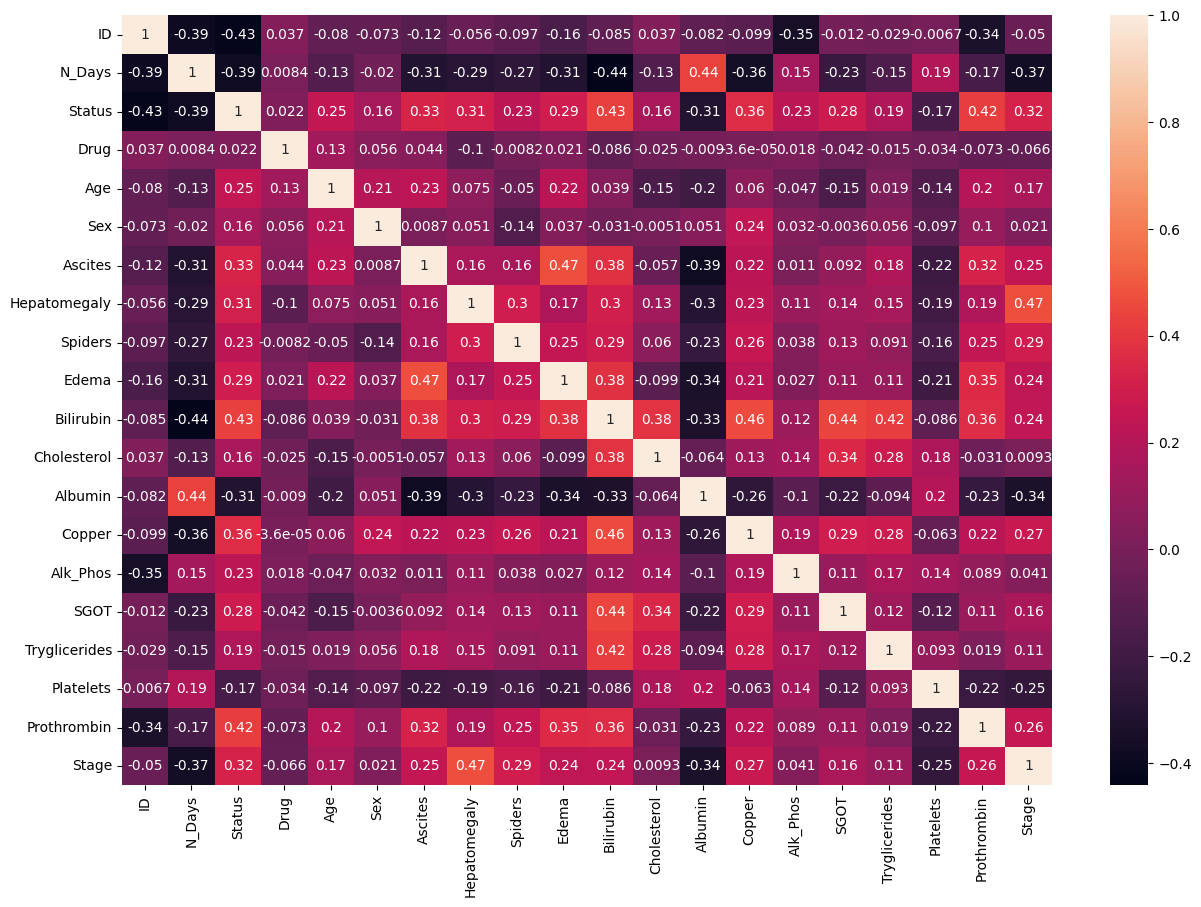

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(cirrhosis_refined.corr(), annot=True)

In [ ]:
cirrhosis_refined.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,1,1,21464,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,0,1,20617,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,1,1,25594,1,0,0,0,1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,1,1,19994,0,0,1,1,1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,0,0,13918,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


### Interpretation of Correlation Matrix

After converting many variables to numerical rather than categorical, we are able to examine the correlation associated with each variable in the dataset. On the whole, there are few variables with a strong correlation. In fact, a quick examination of the correlation coefficients show that the highest correlation coefficient is 0.47, between the cirrhosis stage and Hepatomegaly. Similarly, we observe a similar correlation coefficient of 0.47 between Ascites and Edema, which makes sense since both of these conditions involve excess fluid in the abdominal cavity.

Additionally, we see a correlation of 0.46 between bilirubin and copper. In researching with Google, it appears that copper and bilirubin interact to form a compound which can worsen cell damage, so these quantities may be associated with one another. Perhaps this is also why the number of days with cirrhosis is associated with bilirubin, since bilirubin refers to waste products developed with cirrhosis.

Looking at albumin, this appears to have strong negative correlations with all other conditions. In researching using the Cleveland Clinic, this is backed because albumin is responsible for retaining fluid inside blood vessels. The absence of this protein can result in the listed conditions, such as edema and ascites. Source: https://my.clevelandclinic.org/health/diseases/22529-hypoalbuminemia

In [ ]:
cirrhosis_refined["Status"].fillna(0)

,Status
0,1
1,0
2,1
3,1
4,0
...,...
307,0
308,0
309,0
310,0


## Model Development

In [ ]:
#Define X and Y feature sets
y=cirrhosis_refined["Status"]
x=cirrhosis_refined.drop(columns="Status")

#Drop rows with null status (outcome variable)
valid_idx = y.notnull()
x = x[valid_idx]
y = y[valid_idx]

Here I use the XGBoost Classifer utilized by Dr.Bent in the Global Explanations notebook.

In [ ]:
## Use of XGBoost Classifier after train_test split
X_train, X_test, y_train, y_test = train_test_split(x, y,\
test_size=0.5)
model = XGBClassifier().fit(X_train, y_train)

## Partial Dependence Plots

In [ ]:
# Choose the feature of interest
features = ["N_Days","Drug","Age","Sex","Ascites","Hepatomegaly","Edema",\
            "Spiders","Bilirubin","Cholesterol","Albumin",'Copper','Alk_Phos',\
            "SGOT","Tryglicerides","Platelets","Stage"]

To prepare a loop for all features, I referenced ChatGPT to see how each of these could be plotted. Additionally, we see that there are errors associated with plotting PDPs for binary indicators. I tried to troubleshoot this using ChatGPT as well, but to no avail. Below, I instead compute the probabilities associated with a value of 0 and a value of 1 for each category, respectively, as an alternative to the PDP.

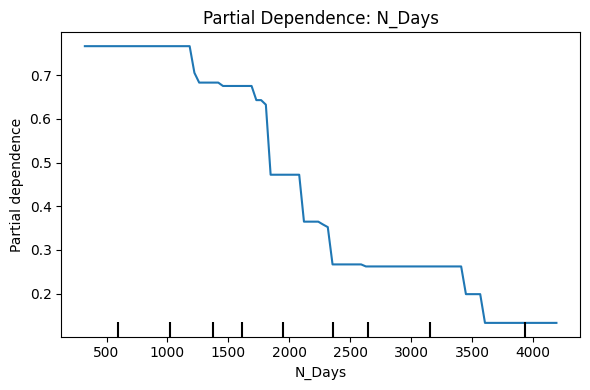

Error with feature 'Drug': cannot reshape array of size 1 into shape (2)


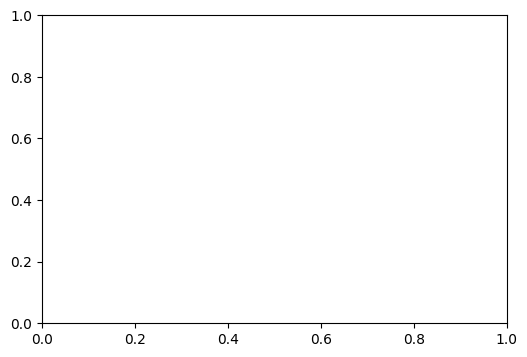

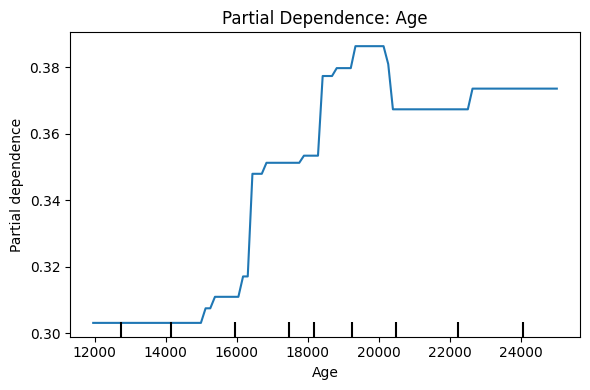

Error with feature 'Sex': cannot reshape array of size 1 into shape (2)
Error with feature 'Ascites': cannot reshape array of size 1 into shape (2)
Error with feature 'Hepatomegaly': cannot reshape array of size 1 into shape (2)
Error with feature 'Edema': cannot reshape array of size 1 into shape (2)
Error with feature 'Spiders': cannot reshape array of size 1 into shape (2)


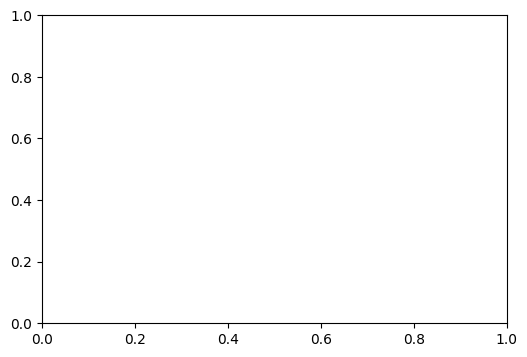

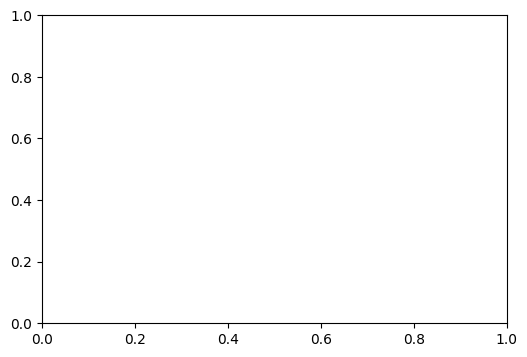

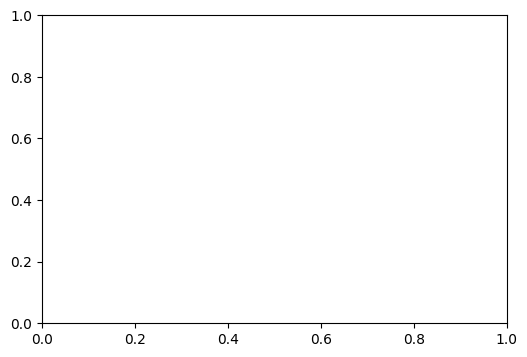

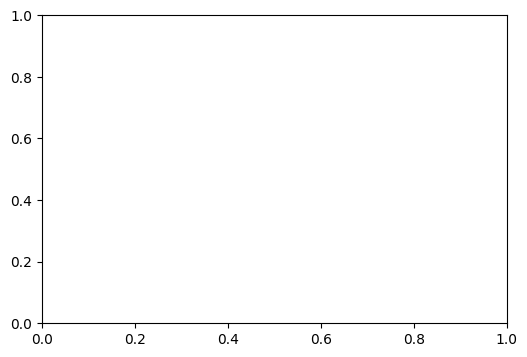

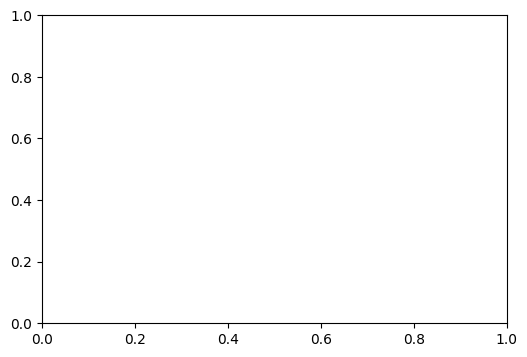

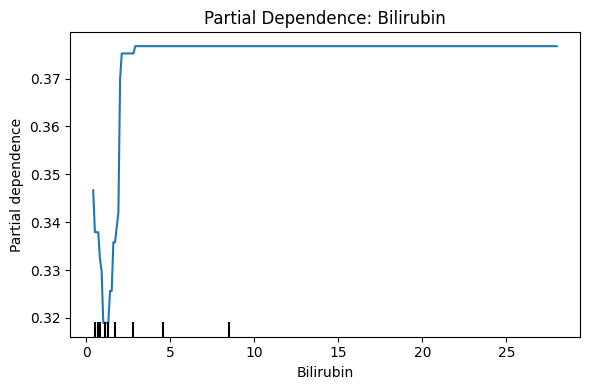

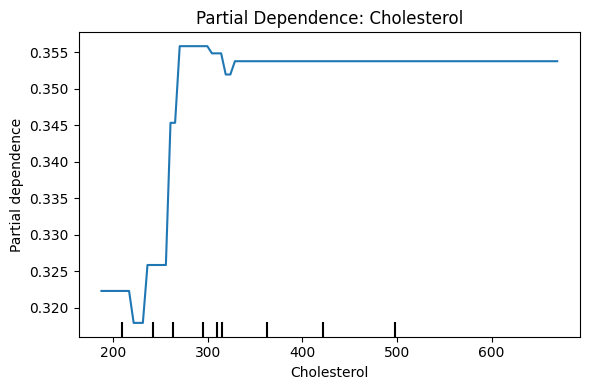

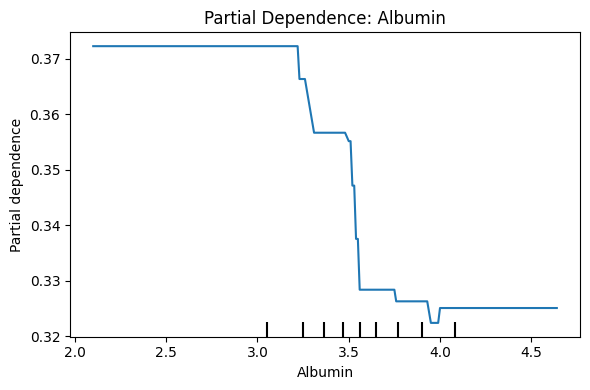

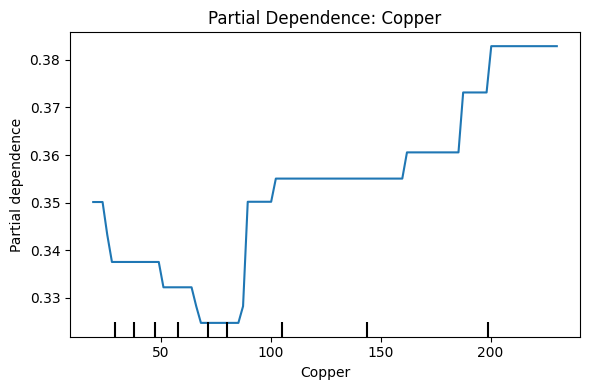

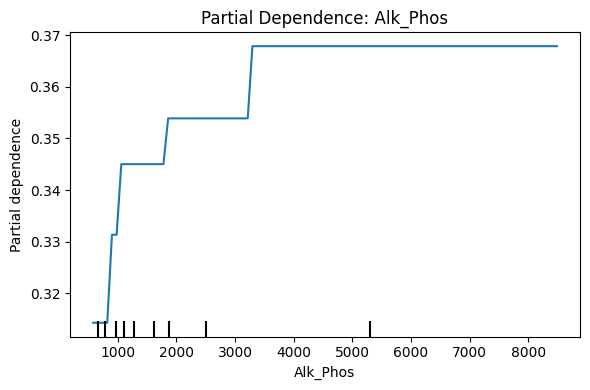

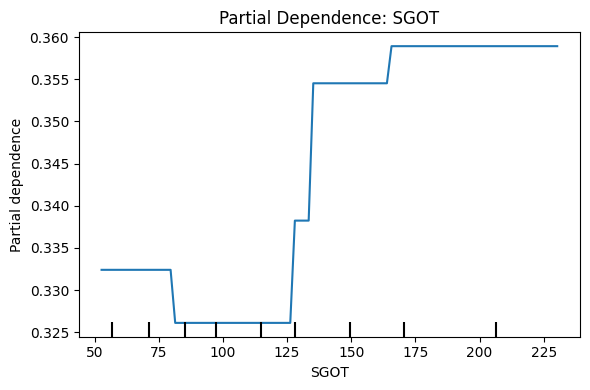

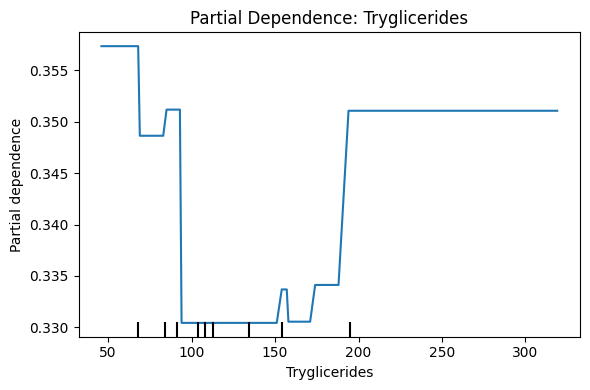

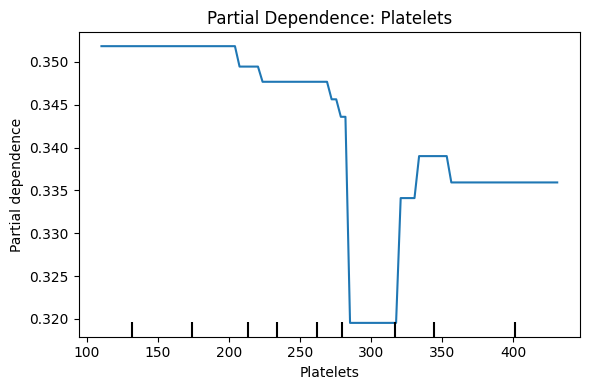

/usr/local/lib/python3.12/dist-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


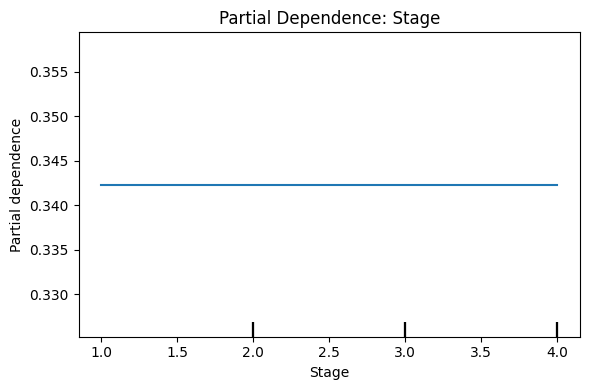

In [ ]:
for feature in features:
    try:
        fig, ax = plt.subplots(figsize=(6, 4))
        PartialDependenceDisplay.from_estimator(model, X_test, [feature], ax=ax)
        plt.title(f'Partial Dependence: {feature}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error with feature '{feature}': {e}")

In the interim, I look to interpret each of the plots which were displayed appropriately above:


*   **N_Days**: We see the number of days with cirrhosis appears to take on a relatively linear form, meaning a consistent decrease in probability of death with more days with the condition. There are certainly hitches, but it appears that beyond the steep dropoff following 1000 days, the change appears to be relatively consistent. There appears to be a plateau here on the upper end of 0.71, meaning cirrhosis with less than 500 days recorded either has fewer values or has little effect on probability of death. This is slightly surprising to me, as I would have expected increasing days with the condition to result in worse condition, and therefore an increased probability of death.
*   **Age**: This is fairly intuitive to me, as increased age results in increased chance of death associated with cirrhosis. We see that this probability really picks up at age 49 (18,000 days), and continues through to age 65. Similarly, there is a large jump at age 57 (21,000 days). There are plateaus on both ends, but likely due to the unavaiability of data associated with patients on either end of the age limit.
*   **Bilirubin**: Perhaps the axis is ineffective to explain, but the current chart shows that very little amounts of bilirubin can really result in consequential impacts on the probability of death. Amounts of bilirubin appear to increase the probability of death, and furthermore, this spike certainly appears around 1 mg of bilirubin. To further this, the plateau on bilirubin occurs around 2.5 mg, and values beyond that do not increase the probability of death. This could make sense, given bilirubin is a waste product, so presence of this could signal poor organ function.
*   **Cholesterol**: While cholesterol appears to exhibit a strong dropoff, I would say this is slightly misleading - a sharp dropoff from 0.37 to 0.35 occurs from around 250 mg to 300 mg. However, this is only a 2% change in probability of death - from there, the curve appears to surge, and is very much linear, rather than an exponential trend. This is in line with what I would expect, with higher cholesterol levels resulting in higher probabilities of death.
*   **Albumin**: Albumin takes on a very interesting, non-linear shape, and similar to cholesterol, does not appear to impact the probability of death in its variation. There appear to be plateaus, where values prior to 3.50 do not appear to impact the probability of death - after 3.8 g/dl, however, there is a sharp decrease that decreases the probability of death. This is what I would expect given Albumin's role in maintaining fluid in blood vessels.
*   **Copper**: Copper appears to have a larger impact than albumin, and again takes on a somewhat convex, non-linear shape. As cholesterol values get to 80 mg/dl, the probability of death appears to remain stable, then a surge occurs after 80-100 mg/dl. Any cholesterol value beyond 120 appears to have little impact on the probability of death, so this is perhaps the plateau. This may be intuitive, as high cholesterol values can exacerbate conditions and increase the risk of death.
*   **Alk_Phos**: Alkaline Phosphatase plays a role in bone mineralization, so we should expect that higher levels would be associated a lower risk of death. Instead, we see the opposite, with an exponential relationship, whereby higher levels of alkaline phosphotase result in a higher probability of death from cirrhosis. Especially around 1750 Units per liter, there appears to be a surge, and then a plateau following 2000 units per liter.
*   **SGOT**: Similarly, SGOT refers to an enzyme used for the metabolism of amino acids in the heart. I would expect this to reduce the risk of death with a higher concentration. Instead, similar to Alk_Phos, we see a similar trend, albeit sharp, whereby higher levels of SGOT result in a higher risk of death. There is a massive spike at 125 U/ml, where the probability of death surges from 0.32 to 0.38, and any value above this does not appear to impact the risk of cirrhosis death. The range of probabilities associated with this enzyme concentration appears to be small, so perhaps it is relatively inconsequential in explaining a death of a patient from cirrhosis.
*   **Tryglicerides**: Tryglicerides is very interesting and counterintuitive here, with a sharp, non-linear dip in the risk of death associated with increased triglycerides. Following 175 mg, it appears that tryglicerides increases the risk of death sharply, but this is on the whole a very small impact, going from 0.33 to 0.35.
*   **Platelets**: Platelets take on a non-linear form, and I would expect the latter half of this chart rather than the initial portion. Based on the chart, there is a plateau, or a fixed risk of death at around 0.345 prior to 225 platelets  - this is intermittently heightened, but then sharply drops around 280 platelets. Again, there is very little dropoff in the risk of death, from .36 to .32, so perhaps this is not very important in impacting the probability of death.
*   **Stage**: Perhaps what I found most surprising was that the stage of cirrhosis is associated with lower risk of death, at least according to this PDP. I believe the lack of data may be responsible for this provided trend, and although it is sharply linear, it appears that a stage 3 patient has a lower risk of death than stage 2, and I believe this would likely be incorrect.



In [ ]:
#Derive probabilities associated with 0 and 1 for each feature
features_binary=["Drug","Sex","Ascites","Hepatomegaly","Edema","Spiders"]
for feature in features_binary:
  X_test_binary_1=X_test.copy()
  X_test_binary_1[feature] = 0
  pred_0 = model.predict_proba(X_test_binary_1)[:, 1].mean()
  X_test_binary_2=X_test.copy()
  X_test_binary_2[feature]= 1
  pred_1 = model.predict_proba(X_test_binary_2)[:, 1].mean()
  print(f"Partial dependence values: {feature}=0 -> {pred_0}, {feature}=1 -> {pred_1}")

Partial dependence values: Drug=0 -> 0.3259497284889221, Drug=1 -> 0.3593975007534027
Partial dependence values: Sex=0 -> 0.3423295319080353, Sex=1 -> 0.3423295319080353
Partial dependence values: Ascites=0 -> 0.3423295319080353, Ascites=1 -> 0.3423295319080353
Partial dependence values: Hepatomegaly=0 -> 0.34364140033721924, Hepatomegaly=1 -> 0.3410433232784271
Partial dependence values: Edema=0 -> 0.3423295319080353, Edema=1 -> 0.3423295319080353
Partial dependence values: Spiders=0 -> 0.3423295319080353, Spiders=1 -> 0.3423295319080353


Since I was unable to plot PDPs for binary values, I have interpreted the calculated values below - additionally, given two values, we can interpret for each that the PDP would be linear.

*   **Drug**: In this case, we can see that the presence of drug therapy reduces the risk of death, from 0.378 to 0.346. This appears to be a marginal difference, so perhaps it is due to the limited data available. However, the decrease associated with the presence of a drug is to be expected.
*  **Sex**: I previously defined Female to be 0 and Male to be 1, so it appears there is consistent probabilites for sexes. I did not expect this, or expected some variation, but it appears sex does not play a role.
*  **Ascites, Edema and Spiders**: All three of these have equal probabilities between the 0 class and 1 class, meaning the presence of these conditions does not appear to impact the risk of death. I am not too familiar with each condition, but each is linked to the absence of albumin, which was previously discussed. I interpret this based on the strong negative correlations between albumin and each of these diseases, so the correlation plot can help inform these results. However, we see albumin is relatively flat when impacting the risk of death associated with cirrhosis.
*   **Hepatomegaly**: Hepatomegaly appears to slightly reduce the probability of death based on the above results, but this refers to an enlargement of the liver. Therefore, I may be skeptical of these results- ultimately with 312 respondents, I wonder if the sample size may play a role here in informing our PDPs and their associated values.

## ALE Plots

I now proceed to chart the Accumulated Local Effects plots, using the code available from Dana Jomar's Github, which I Google Searched. I link the github below:
https://github.com/DanaJomar/PyALE

INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.


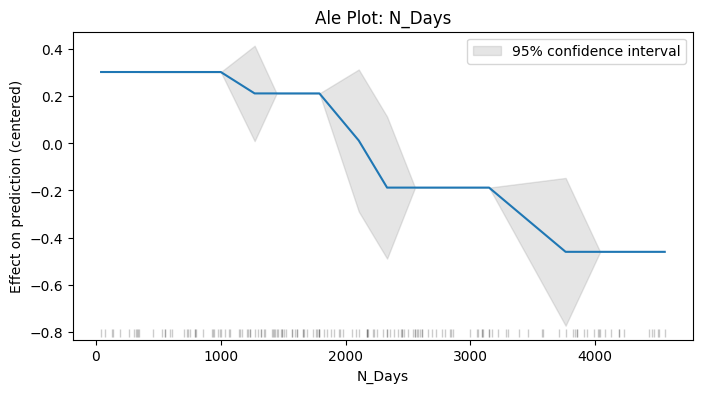

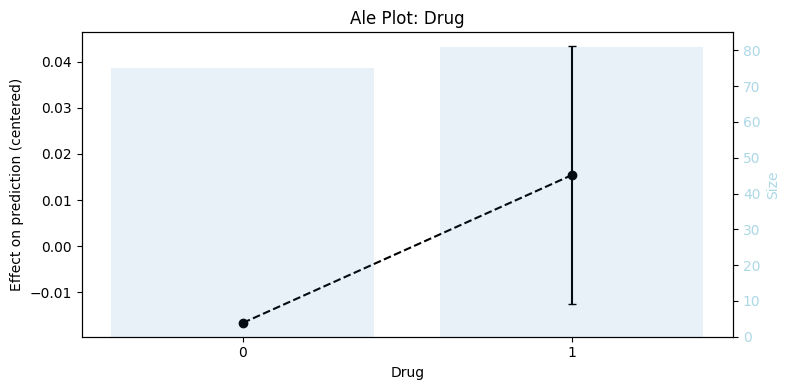

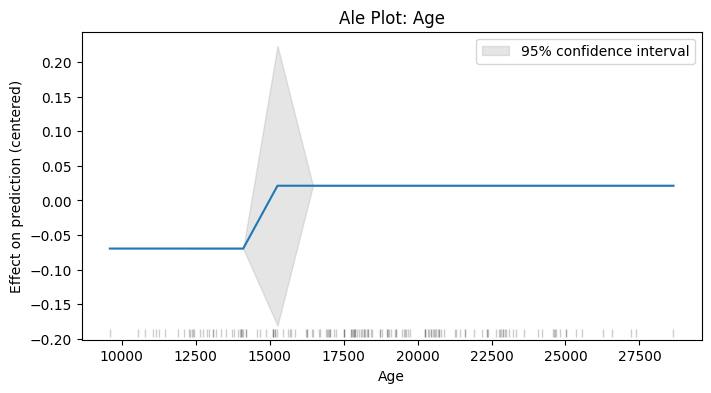

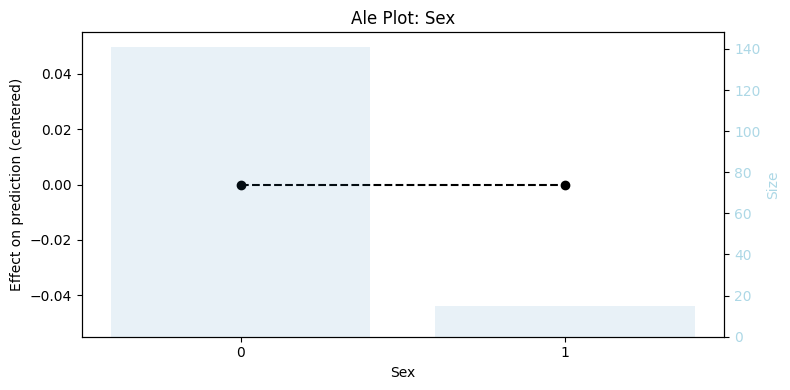

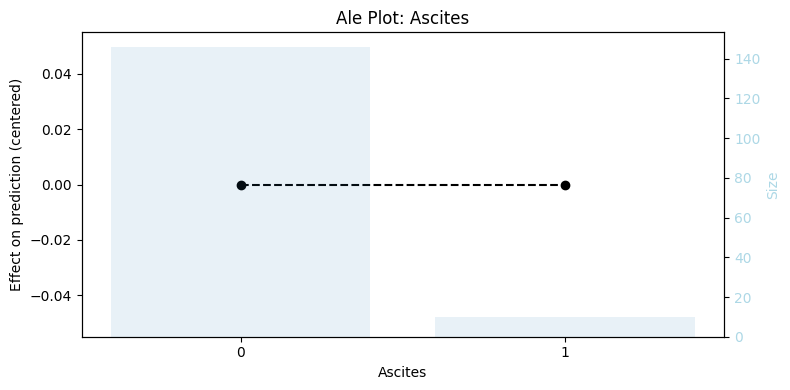

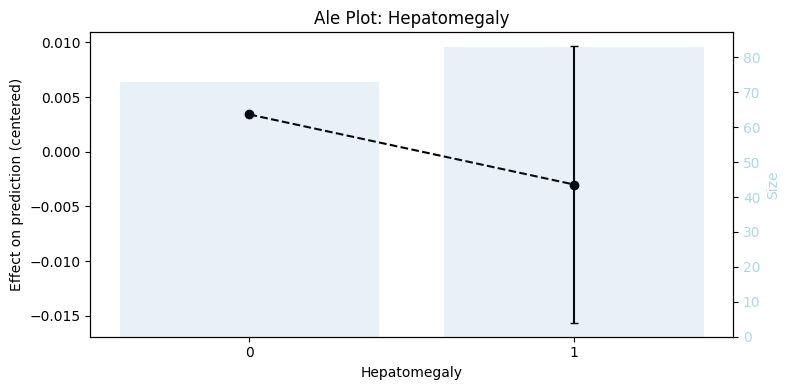

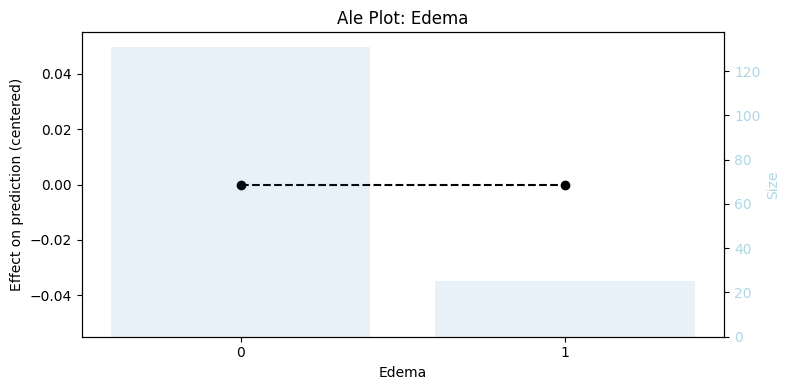

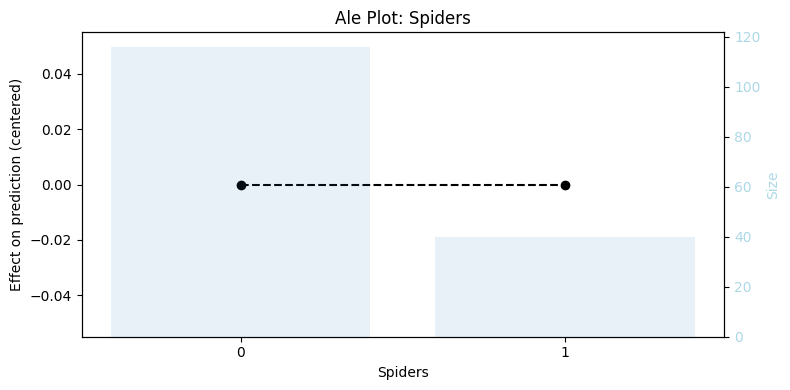

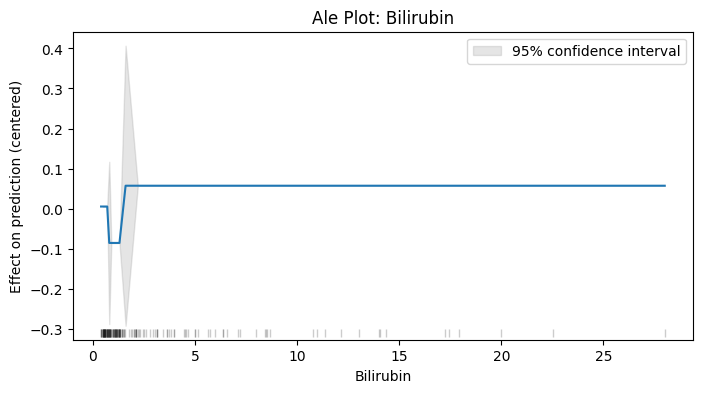

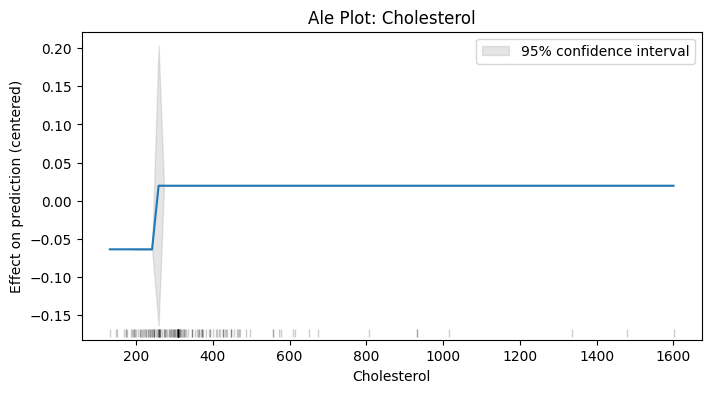

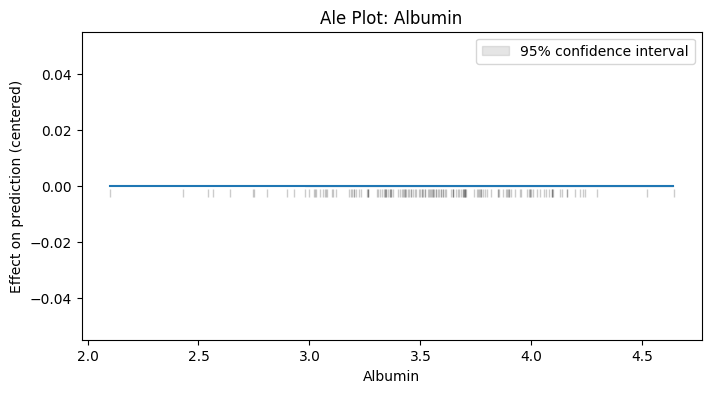

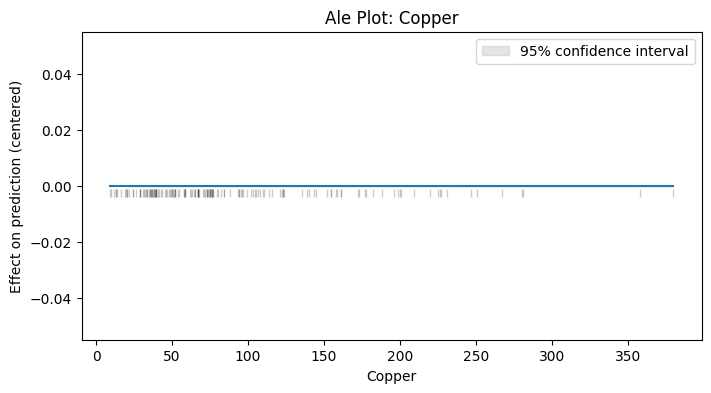

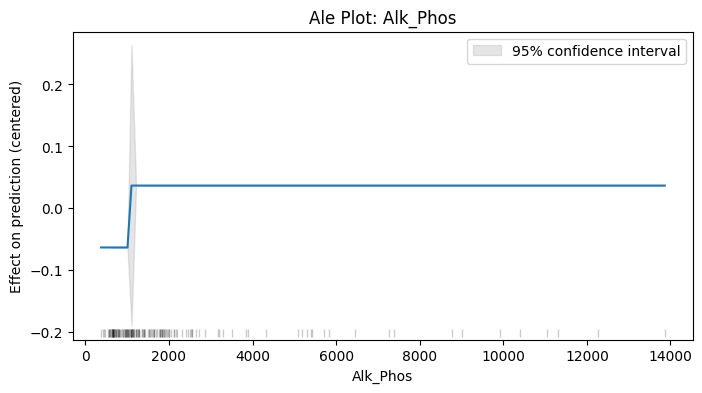

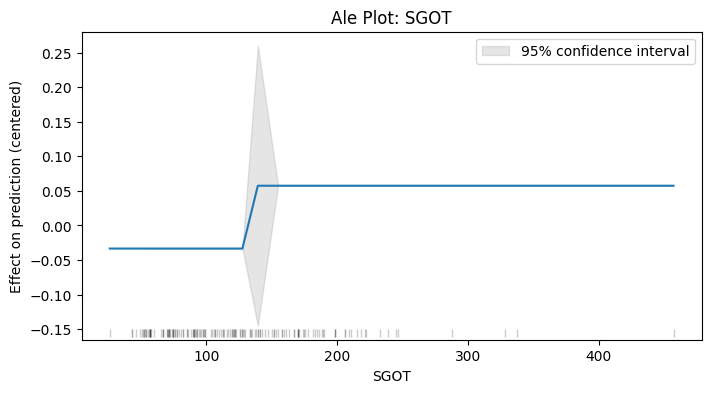

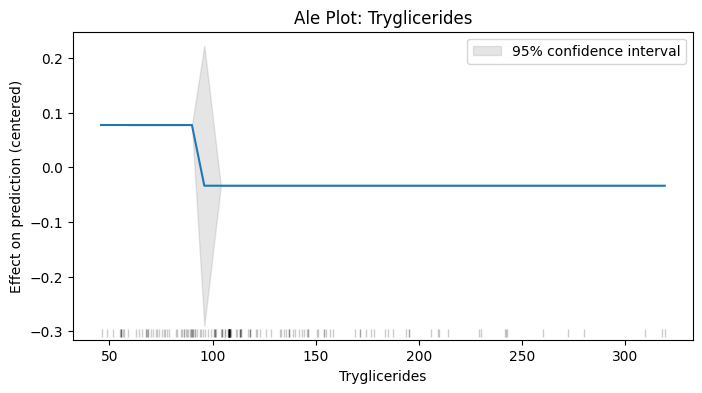

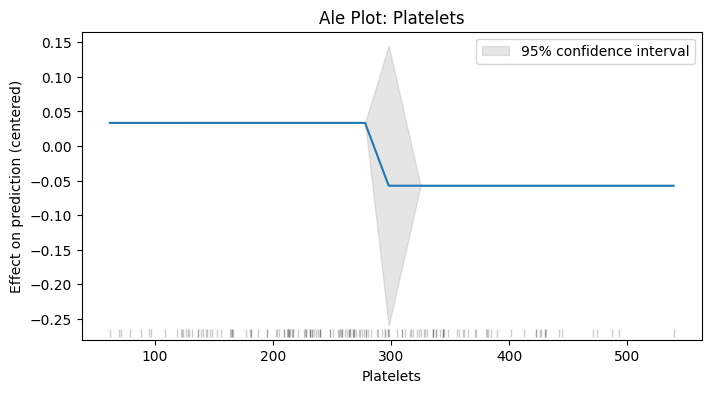

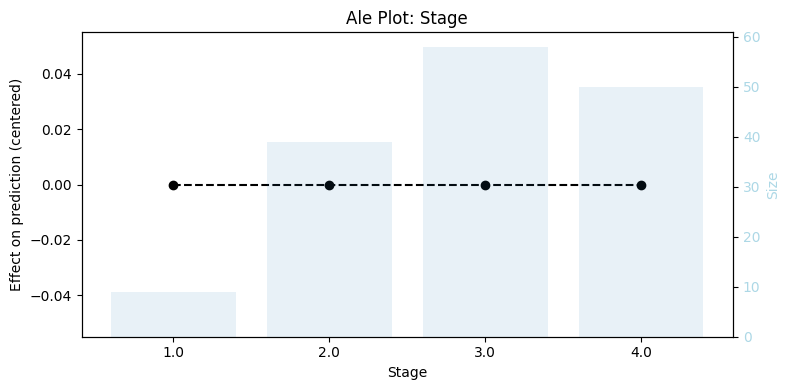

In [ ]:
for feature in features:
  #fig, ax = plt.subplots(figsize=(6, 4))
  ale_eff = ale(
    X=X_test, model=model, feature=[feature], grid_size=15, include_CI=True,\
    C=0.95
)
  plt.title(f'Ale Plot: {feature}')

## Interpretation of ALE plots

In reviewing the above plots, there appear to be many features which did not impact prediction figures based on the ALE plots displayed. Given the limited dataset, I saw on ChatGPT that it may be preferable to limit the number of bins - therefore, I chose to display using 20 bins, given more could result in distortion of each feature's impact. However, the features that did not in impact on prediction probability include: Stage, Copper, Albumin, Spiders, Edema, Ascites, and Sex. Therefore I proceed to interpret the other variables:

*   **N_Days**: Based on the ALE plot, we see that similar to the PDP, the number of days appears to reduce the probability of cirrhosis-induced death. This is once again surprising, but this is reinforced in the exploratory correlation matrix, where there was a relatively strong negative correlation between Status and the Number of Days.
*   **Drug**: Based on the ALE plot, the presence of the drug appears to marginally increase the risk of death from cirrhosis. Given how large the confidence interval is, where even negative values are included, it appears that the ALE plot is determinative on the impact of drug therapy on the risk of death from cirrhosis.
*   **Age**: The ALE plot shows a linear association between age and the risk of death, where around the age of 37, there is a sharp increase in the risk of death, and then it remains flat from 40 onwards. The 10% difference perhaps indicates that with age above 40, there is a 10% absolute difference in the risk of death from cirrhosis compared to an age 37 or less.
*   **Hepatomegaly**: Similar to the drug feature, the presence of hepatomegaly appears to result in a decrease in the risk of death, but the 95% confidence interval is so large, and includes positive values, that it is difficult to make a determination conclusively regarding the impact of an enlarged liver. The smaller sample size likely impacts the true interpretation of this feature.
*   **Bilirubin**: Bilirubin initially has a dip in probability of death associated with 1 mg/dl, but then experiences a sharp increase in the risk of death afterwards. This appears to be a significant predictor, given the range of probabilities: those with over 1 mg/dl of bilirubin appear to have a 20% higher probability of death than those with 0.8 mg/dl of bilirubin, but this is also perhaps due to the limited data.
*   **Cholesterol**: Cholesterol seems to be in concurrence with the PDP plot, where the jump in the probability of death comes at 280 mg/dl. Moreover, there is also a plateau, similar to the PDP plot, at valuea of 300 mg/dl or more of cholesterol.
*   **Alk-Phos**: The ALE plot is very much in concurrence with the PDP plot, where there is also a sharp increase in probability of death around 1000 U/dl. This runs once again counter to my expectation, where the presence of such an enzyme would be expected to improve health and reduce the risk of death. Given the range is higher than that of cholesterol, this is perhaps a more consequently factor when predicting the risk of death.
*   **SGOT**: Previously, the PDP plot had an effect in probability of death when the SGOT value fell on the other side of 125 units - the ALE plot appears to show the same, where values above 150 result in a plateau, and there is a sharp increase in the risk of death in the same area.
*   **Triglycerides**: Once again, the ALE plot mirrors the PDP plot, and shows a dropoff in the probability of death on the increased side of 100 mg/dl. This also better articulates the percentage change in probability associated with such values - patients with over 100 mg/dl appear to have a 12% lower risk of death from cirrhosis compared to those with less than 100 mg/dl.
*   **Platelets**: It is interesting that the ALE plot and PDP plots take on identical forms with respect to plateletes when there is a decrease - the delta in the probability of death occurs right around the same platelet count. However, these differ on the other side of 300 platelets, where the PDP experiences a rise, while the ALE plot plateaus in the risk of death. I wonder if this is due to the bin size, and insufficient bins used to articulate the different changes in platelet count.

## ICE Plots

I am still getting errors applying ICE plots to binary variables - therefore for the purpose of this exercise, I will try to re-update the original cirrhosis dataset to get dummy variables for the categorical features so that they can be reconciled with the previous results I am able to get.

In [ ]:
cirrhosis_new=cirrhosis[0:312]

In [ ]:
cirrhosis_new["Edema"] = cirrhosis_new["Edema"].replace({"S": "Y"})
cirrhosis_new["Status"] = cirrhosis_new["Status"].replace({"CL": "C"})

/tmp/ipython-input-1469172599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_new["Edema"] = cirrhosis_new["Edema"].replace({"S": "Y"})
/tmp/ipython-input-1469172599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_new["Status"] = cirrhosis_new["Status"].replace({"CL": "C"})


In [ ]:
cirrhosis_encoded = pd.get_dummies(cirrhosis_new, columns=['Drug','Sex','Edema','Status','Ascites','Hepatomegaly','Spiders'], drop_first=True)

In [ ]:
cirrhosis_encoded.head()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_Placebo,Sex_M,Edema_Y,Status_D,Ascites_Y,Hepatomegaly_Y,Spiders_Y
0,1,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,False,False,True,True,True,True,True
1,2,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,False,False,False,False,False,True,True
2,3,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,False,True,True,True,False,False,False
3,4,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,False,False,True,True,False,True,True
4,5,1504,13918,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,True,False,False,False,False,True,True


In [ ]:
#Define X and Y feature sets
y_enc=cirrhosis_encoded["Status_D"]
x_enc=cirrhosis_encoded.drop(columns=["ID","Status_D"])

#Drop rows with null status (outcome variable)
valid_idx_enc = y_enc.notnull()
x_enc = x_enc[valid_idx_enc]
y_enc = y_enc[valid_idx_enc]

In [ ]:
x_enc

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_Placebo,Sex_M,Edema_Y,Ascites_Y,Hepatomegaly_Y,Spiders_Y
0,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,False,False,True,True,True,True
1,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,False,False,False,False,True,True
2,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,False,True,True,False,False,False
3,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,False,False,True,False,True,True
4,1504,13918,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1153,22347,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0,False,False,False,False,True,False
308,994,21294,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0,True,False,False,False,False,False
309,939,22767,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0,False,False,False,False,False,False
310,839,13879,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0,False,False,False,False,False,False


x_enc

In [ ]:
## Use of XGBoost Classifier after train_test split
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(x_enc, y_enc,\
test_size=0.5)
model_enc = XGBClassifier().fit(X_train_enc, y_train_enc)

**Despite trying encoding and trying to debug, I am still running into the same issue with binary variables:**
"ValueError: cannot reshape array of size 1 into shape (2)".

**Therefore, I will proceed by interpreting the ICE plots for the remaining variables, and comparing them to the charts from previous techniques**

In [ ]:
feature_lim=["N_Days","Age","Bilirubin","Cholesterol","Albumin",'Copper','Alk_Phos',\
            "SGOT","Tryglicerides","Platelets","Stage"]

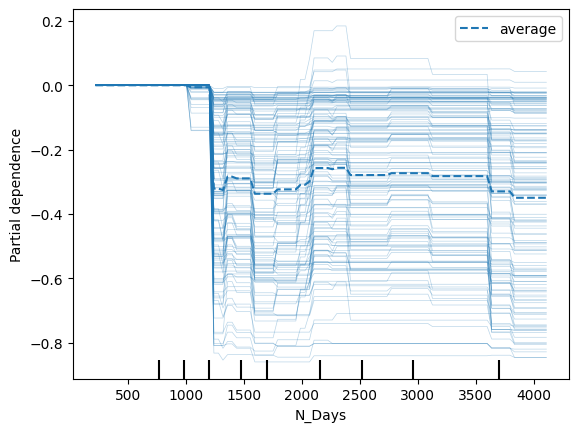

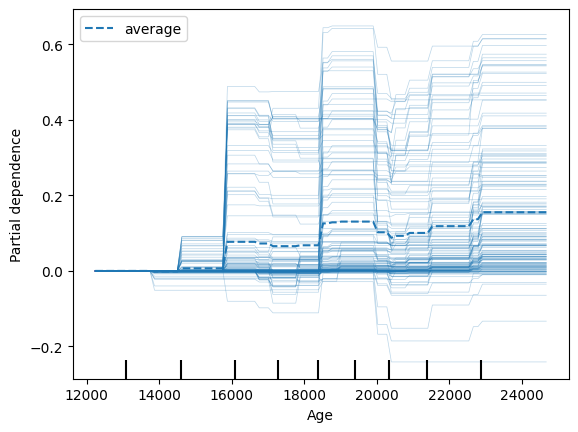

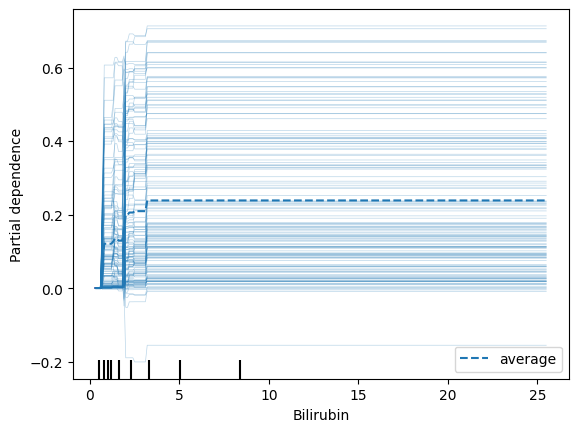

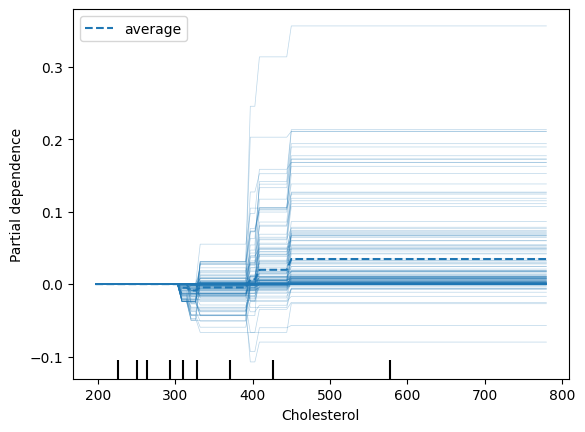

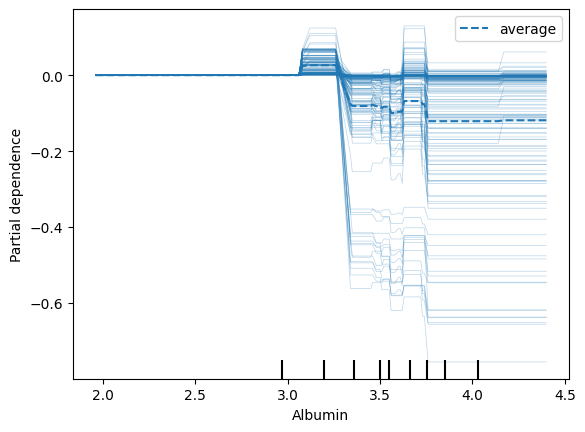

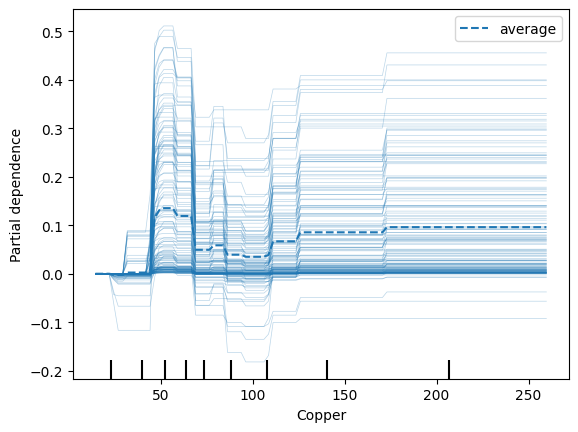

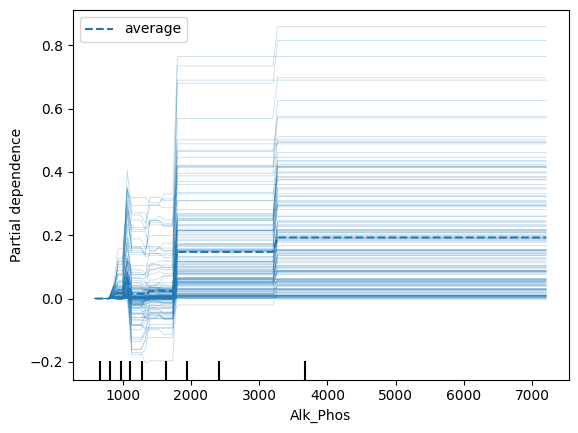

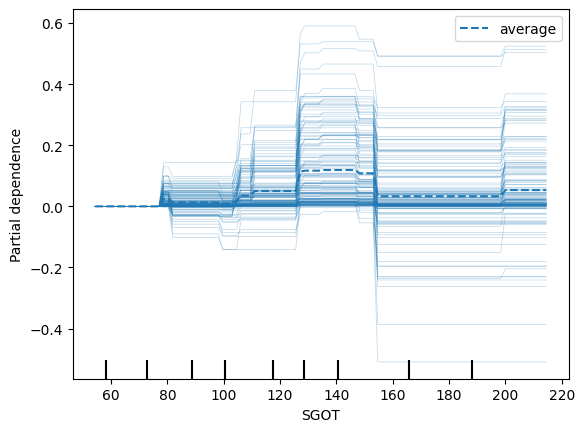

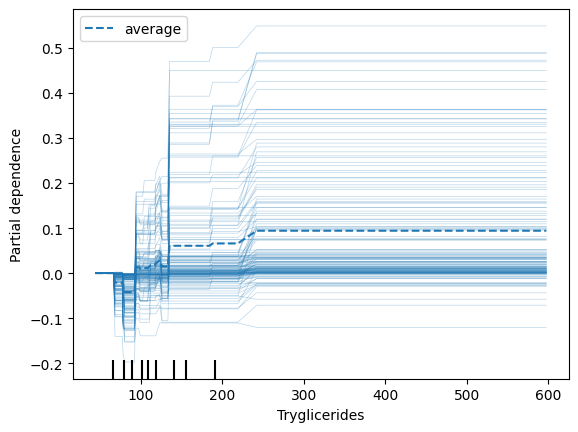

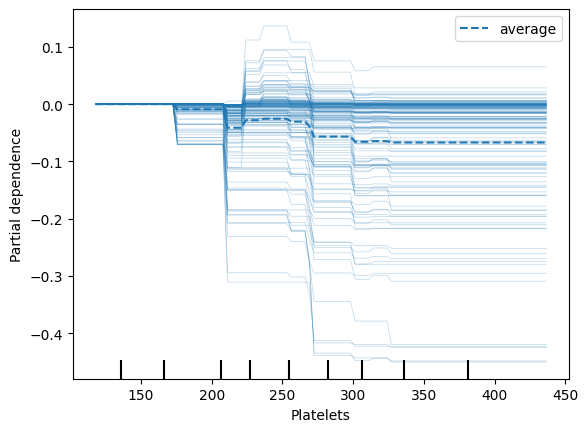

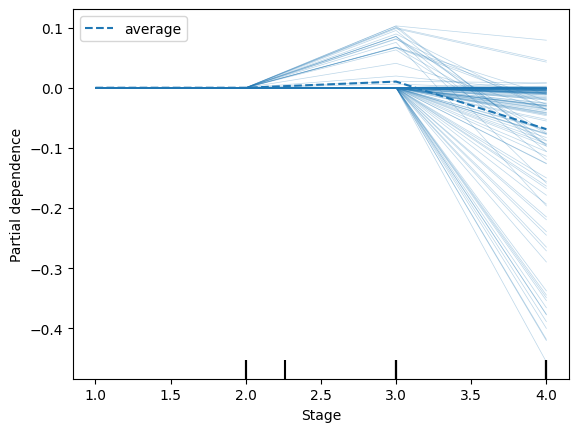

In [ ]:
for feature in feature_lim:
  PartialDependenceDisplay.from_estimator(model_enc, X_test_enc, [feature], kind='both', centered=True)

These centered ICE plots are very interesting, and I believe perhaps these show the results if they had not been averaged, as perhaps had been the case with the ALE plots. I proceed to interpret each variable:

*   **N_Days**: It is interesting to see that unlike the ALE or PDP plots, there is not a continuous dropoff associated with the number of days. Instead, there is a sharp decline in 1000 days associated with the risk of death, but it perhaps plateaus after this.
*   **Age**: While is not linear, the age variable experiences gradual levels to increased probability of death. This appears to mirror the PDP, as the ICE plot features a broader range of numbers on the axis, but appears to show the same difference in probability in each step. This is intuitive, as increased age likely results in increased probability of death.
*   **Bilirubin**: Bilirubin features very similar trends to the PDP and ALE plots - specifically, around 1 mg/dl, the probability of death appears to surge. In this case, based on the average of the centered ICE plot, this results in a 20% increase in the risk of death if one is on the other side of 1 mg/dl. This makes sense given bilirubin is the waste product which may slow metabolism.
*   **Cholesterol**: While cholesterol takes on a shape similar to the ICE and ALE plots, where it increases in levels with increased cholesterol, the ICE plot differs significantly on when this occurs. The ICE plot appears to show increases closer to 400 and 500 mg/dl, while the PDP and ALE plots show this closer to 250-300 mg/dl.
*   **Albumin**: Previously, we would have expected increased albumin to result in lower risk of death thanks to its importance in maintaining fluid in blood vessels. Looking at the ICE plot, we find a trend similar to the PDP plot, where a figure greater than 3.5 results in a dropoff in the risk of death.This effect looks to be close to 10-15%.
*   **Copper**: Copper takes on an interesting trend, where it initially increases the risk of death, but then subsequently lowers around 75 mg before going the risk of death goes back up slowly yet consistently. While the ALE plot did not product much change, this ICE plot appears to mirror the PDP.
*   **Alk_Phos**: Based on the centered ICE plot, we see that there are levels at which the risk of death increases with increases Alk-Phos, specifically 2000 and 3000 U/dl. This looks to mirror the ALE plot, specifically the increase in probability around 2000 U/dl.
*   **SGOT**: Another enzyme here, we see a nonlinear shape associated with SGOT on the risk of death. Unlike either the PDP or ALE plots, the ICE plot appears to show a plateau following a decrase, while the previously referenced plots show an increase at the end of the range of SGOT values.
*   **Triglycerides**: As I had previously expected, triglycerides takes on a linear form as it is associated with increased risk of death. This differs significantly from both the ALE and PDP plots, which showed triglycerides as mostly decreasing the risk of death.
*   **Platelets**: Platelets are relatively consistent with other interpretations, whereby increased platelet account is resulting in a lower risk of death. Overall, however, there appears to be only an 8% difference across the range of platelet counts. While the areas at which the curve changes are different, this appears to take on similar shapes between all three plots.
*   **Stage**: The centered ICE plot, despite falling more in line with previously-held assumptions, still appears to differ to me. Again, this centered ICE plot implies that Stage 4 patients have lower risk of death than do Stage 3 patients. This mirrors the PDP implication, which I am not sure I believe. There is a slight rise between Stage 2 and Stage 3, which might be further supported if more data were to be collected.